# Comparing Models on a Correct Sample of Value 9

Since our incorrect sample was a 9, and from the frequency error graphs 9 were somewhat problematic, I wanted to investigate what a correctly classified 9 looks like.

## Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import torch
from torch import nn

from helpers import load_images, load_labels, visualize_image, get_edges, generate_intermediate_edge_labels

## Set Device to Cuda

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"We will be using device: {device}")

We will be using device: cuda


## Get Test Data and Sub Labels

In [3]:
horizontal_kernel = np.array([
    [-1, -1, -1],
    [ 0,  0 , 0],
    [ 1,  1,  1],
])

vertical_kernel = np.array([
    [-1,  0,  1],
    [-1,  0,  1],
    [-1,  0,  1],
])

In [4]:
# test data
test_images = load_images("./data/t10k-images-idx3-ubyte/t10k-images-idx3-ubyte")
test_labels = load_labels("./data/t10k-labels-idx1-ubyte/t10k-labels-idx1-ubyte")

# sub labels
test_horizontal_image_labels = generate_intermediate_edge_labels(test_images, horizontal_kernel)
test_vertical_image_labels = generate_intermediate_edge_labels(test_images, vertical_kernel)

In [5]:
def get_sample(idx):
    return test_images[idx], test_labels[idx], test_horizontal_image_labels[idx].reshape(28, 28), test_vertical_image_labels[idx].reshape(28, 28)

## Load Models

In [6]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        layer_size_by_pixels = 28*28
        
        self.flatten = nn.Flatten()
        
        # define layers separately to have access to each
        self.horizontal_layer = nn.Linear(layer_size_by_pixels, layer_size_by_pixels)
        self.vertical_layer = nn.Linear(layer_size_by_pixels, layer_size_by_pixels)
        self.classification_layer = nn.Linear(layer_size_by_pixels, 10)
        self.activation_function = nn.ReLU()

    def forward(self, x):
        x = self.flatten(x)

        # horizontal processing
        horizontal_out = self.horizontal_layer(x)
        horizontal_act = self.activation_function(horizontal_out)

        # vertical processing
        vertical_out = self.vertical_layer(horizontal_act)
        vertical_act = self.activation_function(vertical_out)

        # classification
        classification_out = self.classification_layer(vertical_act)
        
        return classification_out, vertical_act, horizontal_act

In [7]:
main_quest_model = NeuralNetwork().to(device)
main_quest_model.load_state_dict(torch.load("./main_quest.pth"))

side_quest_model = NeuralNetwork().to(device)
side_quest_model.load_state_dict(torch.load("./side_quests.pth"))

partial_side_quest_model = NeuralNetwork().to(device)
partial_side_quest_model.load_state_dict(torch.load("./partial_side_quests.pth"))

<All keys matched successfully>

## Activation and Sample Exploration

In [8]:
def convert_tensor_to_np_arr(img_tensor):
    return np.abs(img_tensor.clone().reshape(28, 28).detach().cpu().numpy())

In [9]:
def convert_numpy_image_to_tensor(img):
    """
    """
    return torch.from_numpy(img.copy()).float().unsqueeze(0).unsqueeze(0).to('cuda')

In [10]:
main_quest_model.eval()
side_quest_model.eval()
partial_side_quest_model.eval()

with torch.no_grad():
    for idx, test_img in enumerate(test_images):
        expected = test_labels[idx]
        if expected == 9:
            img_tensor = convert_numpy_image_to_tensor(test_img)
            
            
            out, v_act, h_act = main_quest_model(img_tensor)
            s_out, s_v_act, s_h_act = side_quest_model(img_tensor)
            p_out, p_v_act, p_h_act = partial_side_quest_model(img_tensor)
    
            if torch.max(out, 1)[1].item() == expected and torch.max(s_out, 1)[1].item() == expected and torch.max(p_out, 1)[1].item() == expected:
                break

In [11]:
print(f"On sample {idx}:")
print(f"\tMain answer: {torch.max(out, 1)[1].item()}")
print(f"\tSide answer: {torch.max(s_out, 1)[1].item()}")
print(f"\tPartial answer: {torch.max(p_out, 1)[1].item()}")
print(f"\tActual answer: {test_labels[idx]}")

On sample 9:
	Main answer: 9
	Side answer: 9
	Partial answer: 9
	Actual answer: 9


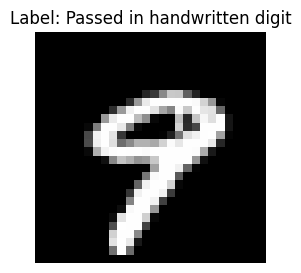

In [12]:
visualize_image(test_img, "Passed in handwritten digit")

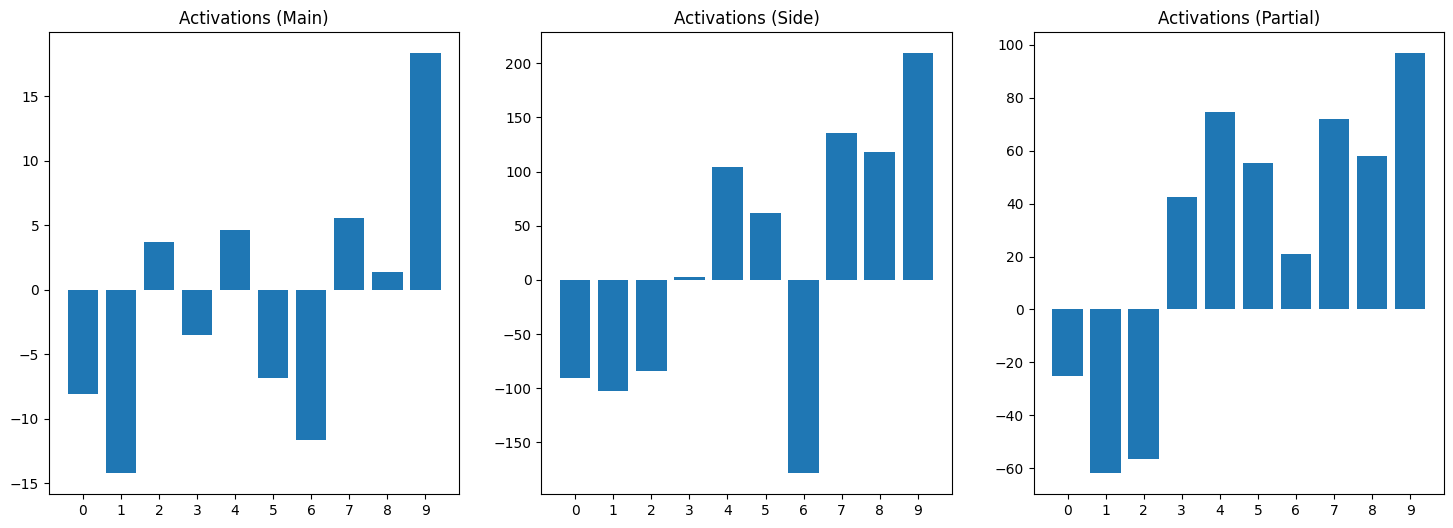

In [13]:
plt.figure(figsize=(18, 6))

x_values = list(range(0, 10))

ax1 = plt.subplot(1, 3, 1)
bars1 = ax1.bar(x_values, out.tolist()[0])
ax1.set_xticks(x_values)
ax1.set_title("Activations (Main)")

ax2 = plt.subplot(1, 3, 2)
bars2 = ax2.bar(x_values, s_out.tolist()[0])
ax2.set_xticks(x_values)
ax2.set_title("Activations (Side)")

ax3 = plt.subplot(1, 3, 3)
bars3 = ax3.bar(x_values, p_out.tolist()[0])
ax3.set_xticks(x_values)
ax3.set_title("Activations (Partial)")

plt.show()

### Horizontal Activation Example

In [14]:
h_act_img = convert_tensor_to_np_arr(h_act)
s_h_act_img = convert_tensor_to_np_arr(s_h_act)
p_h_act_img = convert_tensor_to_np_arr(p_h_act)

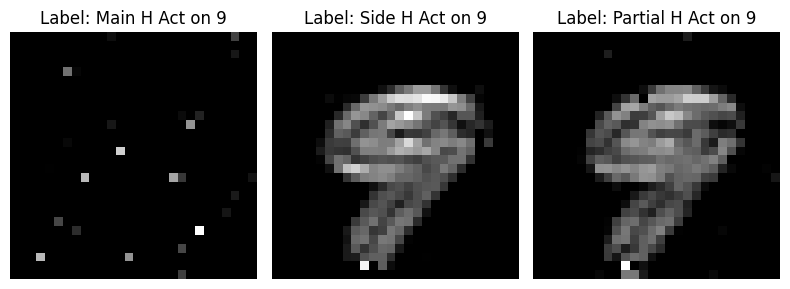

In [15]:
fig, axes = plt.subplots(1, 3, figsize=(8, 5))

label = 9
visualize_image(h_act_img, f"Main H Act on {label}", ax=axes[0])
visualize_image(s_h_act_img, f"Side H Act on {label}", ax=axes[1])
visualize_image(p_h_act_img, f"Partial H Act on {label}", ax=axes[2])

plt.tight_layout()
plt.show()

### Vertical Activation Example

In [16]:
v_act_img = convert_tensor_to_np_arr(v_act)
s_v_act_img = convert_tensor_to_np_arr(s_v_act)
p_v_act_img = convert_tensor_to_np_arr(p_v_act)

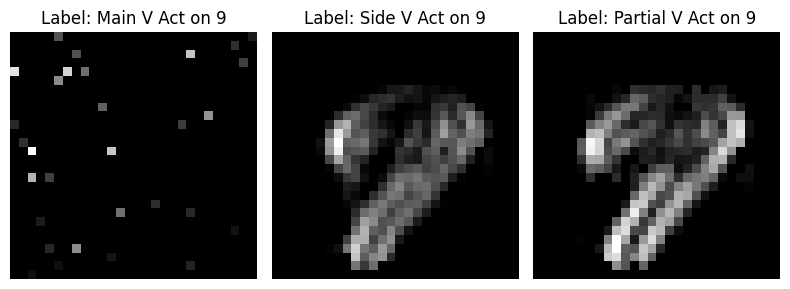

In [17]:
fig, axes = plt.subplots(1, 3, figsize=(8, 5))

visualize_image(v_act_img, f"Main V Act on {label}", ax=axes[0])
visualize_image(s_v_act_img, f"Side V Act on {label}", ax=axes[1])
visualize_image(p_v_act_img, f"Partial V Act on {label}", ax=axes[2])

plt.tight_layout()
plt.show()

So, with edges we can identify a 9, but I am wondering more and more about incorporating a curve layer.

So, in addition messing around with the ordering of layers, I think adding another layer that focuses on recognizing curves would be useful. This would be the third side quest of this project. Theoretically, this third part should handle everything we need: going horizontally, going vertically, and curving.